In [1]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import linregress

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors

import warnings
warnings.filterwarnings('ignore','SerializationWarning')

%load_ext autoreload
%autoreload 2

In [2]:
from defs import Zonal_SST_gradient, trim_axs, Nino34_timeseries

In [3]:
figwidth1 = 8.3;
figwidth2 = 12;
labelfontsize = 13;
legendfontsize = 12;
titlefontsize = 13;

## load observations

In [4]:
## HadISST data
## https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html
## 1870 - 2020 SST data

file = 'observations/HadISST/HadISST_sst.nc'
ds   = xr.open_dataset(file)

# select last 100 years
ds = ds.sel(time=slice("1920", "2019"))

# -180 to 180 transform to 0 - 360
ds.coords['longitude'] = (ds.coords['longitude'] - 360) % 360
ds = ds.sortby(ds.longitude)
ds = ds.sortby(ds.latitude)

# slice equatorial pacific
minlat = -23;  maxlat = 23; minlon = 140; maxlon = 280;
AM_ssts = ds.sst.sel(latitude = slice(minlat, maxlat)).sel(longitude = slice(minlon, maxlon)).mean(dim='time')

# slice equatorial pacific
minlat = -5;  maxlat = 5; minlon = 140; maxlon = 280;
ds = ds.sel(latitude = slice(minlat, maxlat)).sel(longitude = slice(minlon, maxlon))

# zonal ssts
SSTs = ds.mean(dim='time').mean(dim='latitude')
hadisst = SSTs.sst.values
lon_hadisst = SSTs.longitude.values

# calculate zonal sst gradient
lonmin_W = 150; lonmax_W = 170;
lonmin_E = 240; lonmax_E = 260;
a = lon_hadisst>lonmin_W; b = lon_hadisst<lonmax_W; lons_W = a*b;
a = lon_hadisst>lonmin_E; b = lon_hadisst<lonmax_E; lons_E = a*b;
zsg_hadisst = np.mean(hadisst[lons_W]) - np.mean(hadisst[lons_E])


In [5]:
# Foley & Dowsett 2019 dataset, KM5c 30k SST

import csv
file = 'observations/cs_mp_sst_data_30k.txt'
# d = open(file,'r')
with open(file, encoding='windows-1252') as f:
    lat = [column[1] for column in csv.reader(f,delimiter='\t')]
with open(file, encoding='windows-1252') as f:
    lon = [column[2] for column in csv.reader(f,delimiter='\t')]
with open(file, encoding='windows-1252') as f:
    prism = [column[3] for column in csv.reader(f,delimiter='\t')]
    
#skip first line + last two (empty)
PRISM_lat = np.zeros(len(lat)-3) 
PRISM_lon = np.zeros(len(lat)-3)    
PRISM_sst = np.zeros(len(lat)-3)    

for i in range(1,len(lat)-2):
    PRISM_lat[i-1] = float(lat[i])
    PRISM_lon[i-1] = float(lon[i])
    PRISM_sst[i-1] = float(prism[i])

PRISM_lon = (PRISM_lon - 360) % 360

a = np.array([PRISM_lon, PRISM_lat, PRISM_sst])
a = a[:,a[0,:]>140]
a = a[:,a[0,:]<280]
a = a[:,a[1,:]>-23]
PRISM_trop = a[:,a[1,:]<23]

hadisst_prismloc = np.zeros(PRISM_trop.shape[1]);
deg = 1.5
for j in range(PRISM_trop.shape[1]):
    hadisst_prismloc[j] = AM_ssts.sel(longitude = slice(PRISM_trop[0,j]-deg, PRISM_trop[0,j]+deg)).sel(
        latitude = slice(PRISM_trop[1,j]-deg, PRISM_trop[1,j]+deg)).mean()

In [93]:
# McClymont et al 2020 dataset, PlioVAR, both UK37 with BAYSLINE calib, and Mg/Ca reconstr
# https://doi.pangaea.de/10.1594/PANGAEA.911847
# last access 26-04-2021

file = 'observations/PlioVAR-KM5c_T.tab'
        
with open(file, encoding='windows-1252') as f:
    ds = [column for column in csv.reader(f,delimiter='\t')]

Nstart = 99; Nend   = len(ds);
iLat   = 2; iLon   = 3; iUk    = 6; iMg    = 7;

PV_lat = np.zeros(Nend-Nstart)
PV_lon = np.zeros(Nend-Nstart)
PV_Uk  = np.zeros(Nend-Nstart)
PV_Mg  = np.zeros(Nend-Nstart)

for i in range(Nstart, Nend):
    PV_lat[i-Nstart] = ds[i][iLat]
    PV_lon[i-Nstart] = ds[i][iLon]
    if ds[i][iUk]=='': PV_Uk[i-Nstart] = np.nan;
    else: PV_Uk[i-Nstart] = ds[i][iUk]
    if ds[i][iMg]=='': PV_Mg[i-Nstart] = np.nan
    else: PV_Mg[i-Nstart] = ds[i][iMg]
PV_lon = (PV_lon - 360) % 360

# select only tropical Pacific data
a = np.array([PV_lon, PV_lat, PV_Uk, PV_Mg])
a = a[:,a[0,:]>140]
a = a[:,a[0,:]<280]
a = a[:,a[1,:]>-23]
PV_trop = a[:,a[1,:]<23]

hadisst_pvloc = np.zeros(PV_trop.shape[1]);
deg = 1.5
for j in range(PV_trop.shape[1]):
    hadisst_pvloc[j] = AM_ssts.sel(longitude = slice(PV_trop[0,j]-deg, PV_trop[0,j]+deg)).sel(
        latitude = slice(PV_trop[1,j]-deg, PV_trop[1,j]+deg)).mean()

## load model data

In [5]:
modellist = ['CCSM4', 'CCSM4-UoT', 'CCSM4-Utr', 'CESM1.2', 'CESM2', 'COSMOS', 'EC-Earth3.3',
             'GISS2.1G', 'HadCM3', 'HadGEM3', 'IPSLCM5A', 'IPSLCM5A2', 'IPSLCM6A', 'MIROC4m', 
             'MRI2.3', 'NorESM-L', 'NorESM1-F']


## Annual means in Tropical Pacific

In [89]:
for i in range(len(modellist)):
    
    model = modellist[i]
    a = Zonal_SST_gradient(model, run = 'E280', latbound = 23, latmean = False)
    b = Zonal_SST_gradient(model, run = 'EOI400', latbound = 23, latmean = False)

    # save for mean annual mean
    if i==0: 
        TPmean_e280   = a.where(a>0, other=0)
        TPmean_eoi400 = b.where(b>0, other=0)
        TP_e280_mask   = np.isnan(a)*1;
        TP_eoi400_mask = np.isnan(b)*1;
    else:
        TPmean_e280   = TPmean_e280 + a.where(a>0, other=0).values           
        TPmean_eoi400 = TPmean_eoi400 + b.where(b>0, other=0)
        TP_e280_mask   = TP_e280_mask + (np.isnan(a)*1).values;
        TP_eoi400_mask = TP_eoi400_mask + (np.isnan(b)*1).values;
        
           
EM_TPms_e280   = TPmean_e280/(len(modellist) - TP_e280_mask)
EM_TPms_eoi400 = TPmean_eoi400/(len(modellist) - TP_eoi400_mask)

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/py

In [143]:
diff = np.zeros(len(modellist))
deg = 0.5
for i in range(len(modellist)):
    
    model = modellist[i]
    a = Zonal_SST_gradient(model, run = 'E280', latbound = 23, latmean = False)
    b = Zonal_SST_gradient(model, run = 'EOI400', latbound = 23, latmean = False)
    
    ds   = b-a.values
    diff[i] = ds.sel(longitude = slice(273-deg, 273+deg)).sel(
        latitude = slice(5.8-deg, 5.8+deg)).mean()

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/py

In [145]:
np.sort(diff)

array([0.11267436, 0.86178792, 0.91316058, 0.97680278, 1.20169439,
       1.41944273, 1.45998646, 1.48878825, 1.63126607, 1.69147156,
       1.69835286, 1.9053243 , 2.06357849, 2.12072062, 2.8040686 ,
       3.65397453, 3.69558006])

In [139]:
lonlist = [152, 159, 236, 269, 273, 275]
latlist = [-9.2, 0.3, 3.8, -3.1, 5.8, 1.2]

ds = EM_TPms_eoi400 - EM_TPms_e280.values

dssts = np.zeros(len(lonlist))
deg = 0.5
for j in range(len(lonlist)):
    dssts[j] = ds.sel(longitude = slice(lonlist[j]-deg, lonlist[j]+deg)).sel(
        latitude = slice(latlist[j]-deg, latlist[j]+deg)).mean()
    
dssts    

array([1.78241401, 1.88799501, 1.91100514, 2.24264265, 1.74698086,
       2.01303098])

array([1.79116851, 1.89230264, 1.91157268, 2.24758799, 1.75224716,
       2.01457017])

# **Figure 7**

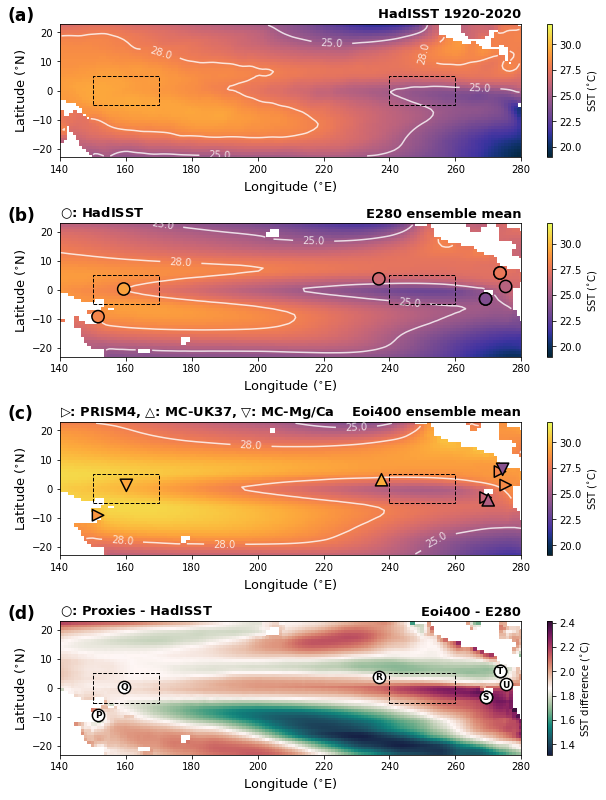

In [228]:
fig2, axs = plt.subplots(nrows=4, ncols=1, figsize=(figwidth1, 11), constrained_layout=True)

Nmask = 3;

clev1 = 25; clev2 = 28;

caption = True
textx = 124; texty = 24; 

lats = [-23, 23]
lons = [140, 280]

vmin = 19; vmax = 32; cmap = plt.get_cmap('cmo.thermal')#, vmax-vmin)

a = EM_TPms_e280
b = EM_TPms_eoi400

ax=axs[0]
AM_ssts.plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cbar_kwargs = dict(label='SST ($^{\circ}$C)', ))
cp1 = AM_ssts.plot.contour(ax=ax, vmin=clev1, vmax=clev1, levels=1, colors='w', zorder =1, alpha=0.8)
cp2 = AM_ssts.plot.contour(ax=ax, vmin=clev2, vmax=clev2, levels=1, colors='w', zorder =1, alpha=0.8)
ax.clabel(cp1, inline=True, fmt = '%2.1f',  fontsize=10); ax.clabel(cp2, inline=True, fmt = '%2.1f',  fontsize=10)
ax.set_title('HadISST 1920-2020', loc='right', fontsize=titlefontsize, fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=labelfontsize)
ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=labelfontsize)
ax.set_title('')
ax.add_patch(Rectangle((150,-5),20,10, fill=False, linestyle='--'));
ax.add_patch(Rectangle((240,-5),20,10, fill=False, linestyle='--'));
if caption == True: ax.text(textx, texty, '(a)', fontsize = 17, fontweight = 'bold')   
    
ax=axs[1]
mask1 = 1 + 0*TP_e280_mask.where(TP_e280_mask<Nmask)
(a*mask1).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,  cbar_kwargs = dict(label='SST ($^{\circ}$C)'))
cp1 = (a*mask1).plot.contour(ax=ax, vmin=clev1, vmax=clev1, levels=1, colors='w', zorder =1, alpha=0.8)
cp2 = (a*mask1).plot.contour(ax=ax, vmin=clev2, vmax=clev2, levels=1, colors='w', zorder =1, alpha=0.8)
ax.clabel(cp1, inline=True, fmt = '%2.1f',  fontsize=10); ax.clabel(cp2, inline=True, fmt = '%2.1f',  fontsize=10)
ax.set_title('E280 ensemble mean', loc='right', fontsize=titlefontsize, fontweight = 'bold')
ax.set_title(r'$\bigcirc$: HadISST', loc='left', fontsize=titlefontsize, fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=labelfontsize)
ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=labelfontsize)
ax.set_title('')
ax.add_patch(Rectangle((150,-5),20,10, fill=False, linestyle='--'));
ax.add_patch(Rectangle((240,-5),20,10, fill=False, linestyle='--'));
if caption == True: ax.text(textx, texty, '(b)', fontsize = 17, fontweight = 'bold')

ax.scatter(PRISM_trop[0,:], PRISM_trop[1,:], marker='o', s=150, edgecolors='k', linewidth=1.5,
           c=hadisst_prismloc, cmap=cmap, vmin = 19, vmax = 32)        
ax.scatter(PV_trop[0,:], PV_trop[1,:], marker='o', s=150, edgecolors='k', linewidth=1.5,
           c=hadisst_pvloc, cmap=cmap, vmin = 19, vmax = 32)      
    
ax=axs[2]
mask2 = 1 + 0*TP_eoi400_mask.where(TP_eoi400_mask<Nmask)
(b*mask2).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cbar_kwargs = dict(label='SST ($^{\circ}$C)'))
cp1 = (b*mask1).plot.contour(ax=ax, vmin=clev1, vmax=clev1, levels=1, colors='w', zorder =1, alpha=0.8)
cp2 = (b*mask1).plot.contour(ax=ax, vmin=clev2, vmax=clev2, levels=1, colors='w', zorder =1, alpha=0.8)
ax.clabel(cp1, inline=True, fmt = '%2.1f',  fontsize=10); ax.clabel(cp2, inline=True, fmt = '%2.1f',  fontsize=10)
ax.set_title('Eoi400 ensemble mean', loc='right', fontsize=titlefontsize, fontweight = 'bold')
ax.set_title(r'$\triangleright$: PRISM4, $\bigtriangleup$: MC-UK37, $\bigtriangledown$: MC-Mg/Ca', loc='left', fontsize=titlefontsize, fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=labelfontsize)
ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=labelfontsize)
ax.set_title('')
ax.add_patch(Rectangle((150,-5),20,10, fill=False, linestyle='--'));
ax.add_patch(Rectangle((240,-5),20,10, fill=False, linestyle='--'));
if caption == True: ax.text(textx, texty, '(c)', fontsize = 17, fontweight = 'bold');

d=.8
ax.scatter(PRISM_trop[0,:], PRISM_trop[1,:], marker='>', s=130, edgecolors='k', linewidth=1.5,
           c=PRISM_trop[2,:], cmap=cmap, vmin = 19, vmax = 32)    
ax.scatter(PV_trop[0,:]+d, PV_trop[1,:]-d, marker='^', s=150, edgecolors='k', linewidth=1.5,
           c=PV_trop[2,:], cmap=cmap, vmin = 19, vmax = 32)   
ax.scatter(PV_trop[0,:]+d, PV_trop[1,:]+d, marker='v', s=150, edgecolors='k', linewidth=1.5,
           c=PV_trop[3,:], cmap=cmap, vmin = 19, vmax = 32)  

ax=axs[3]; 
d = 0.55; #np.mean(b-a); 
vmin = np.mean(b-a)-d; vmax = np.mean(b-a)+d;
cmap = plt.get_cmap('cmo.curl');
(mask1*mask2*(b-a)).plot(ax=ax, vmin = vmin, vmax = vmax,
           cmap=cmap, cbar_kwargs = dict(label='SST difference ($^{\circ}$C)'))
ax.set_title('Eoi400 - E280', loc='right', fontsize=titlefontsize, fontweight = 'bold')
ax.set_title(r'$\bigcirc$: Proxies - HadISST', loc='left', fontsize=titlefontsize, fontweight = 'bold')
ax.set_xlim(lons[0], lons[1]); ax.set_ylim(lats[0], lats[1]);
ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=labelfontsize)
ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=labelfontsize)
ax.set_title('')
ax.add_patch(Rectangle((150,-5),20,10, fill=False, linestyle='--'));
ax.add_patch(Rectangle((240,-5),20,10, fill=False, linestyle='--'));
if caption == True: ax.text(textx, texty, '(d)', fontsize = 17, fontweight = 'bold');

ax.scatter(PRISM_trop[0,:], PRISM_trop[1,:], marker='o', s=150, edgecolors='k', linewidth=1.5,
           c='w', cmap=cmap, vmin = vmin, vmax = vmax)
ax.scatter(PV_trop[0,:], PV_trop[1,:], marker='o', s=150, edgecolors='k', linewidth=1.5,
           c='w', cmap=cmap, vmin = vmin, vmax = vmax)

textlist = ['U','S','P','T']
dl = 1;
for i in range(4):
    ax.text(PRISM_trop[0,i]-dl, PRISM_trop[1,i]-dl, textlist[i],fontsize=9, fontweight='bold')
ax.text(PV_trop[0,2]-dl, PV_trop[1,2]-dl, 'Q',fontsize=9, fontweight='bold')
ax.text(PV_trop[0,1]-dl, PV_trop[1,1]-dl, 'R',fontsize=9, fontweight='bold')

# ax.text(127, -37, 'FD19:', fontsize=11, fontweight = 'bold')
# ax.text(140, -35, 'P = 0.50$^{\circ}$C,  S1 = 2.6$^{\circ}$C,', fontsize=11, fontweight = 'bold')
# ax.text(140, -40, 'T1 = 0.45$^{\circ}$C, U = 3.0$^{\circ}$C.', fontsize=11, fontweight = 'bold')

# ax.text(237, -35, 'MC-UK37: R = 3.1$^{\circ}$C,  S2 = 1.7$^{\circ}$C,', fontsize=11, fontweight = 'bold')
# ax.text(237, -40, 'MC-Mg/Ca: Q = 0.13$^{\circ}$C, T2 = -3.6$^{\circ}$C.', fontsize=11, fontweight = 'bold')
    
# plt.savefig('figures/TPmean_SSTs.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/TPmean_SSTs.pdf', bbox_inches='tight')
# plt.savefig('figures/figure7.pdf', bbox_inches='tight')

## Zonal SSTs & gradients

# **Appendix Figure 4**

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/py

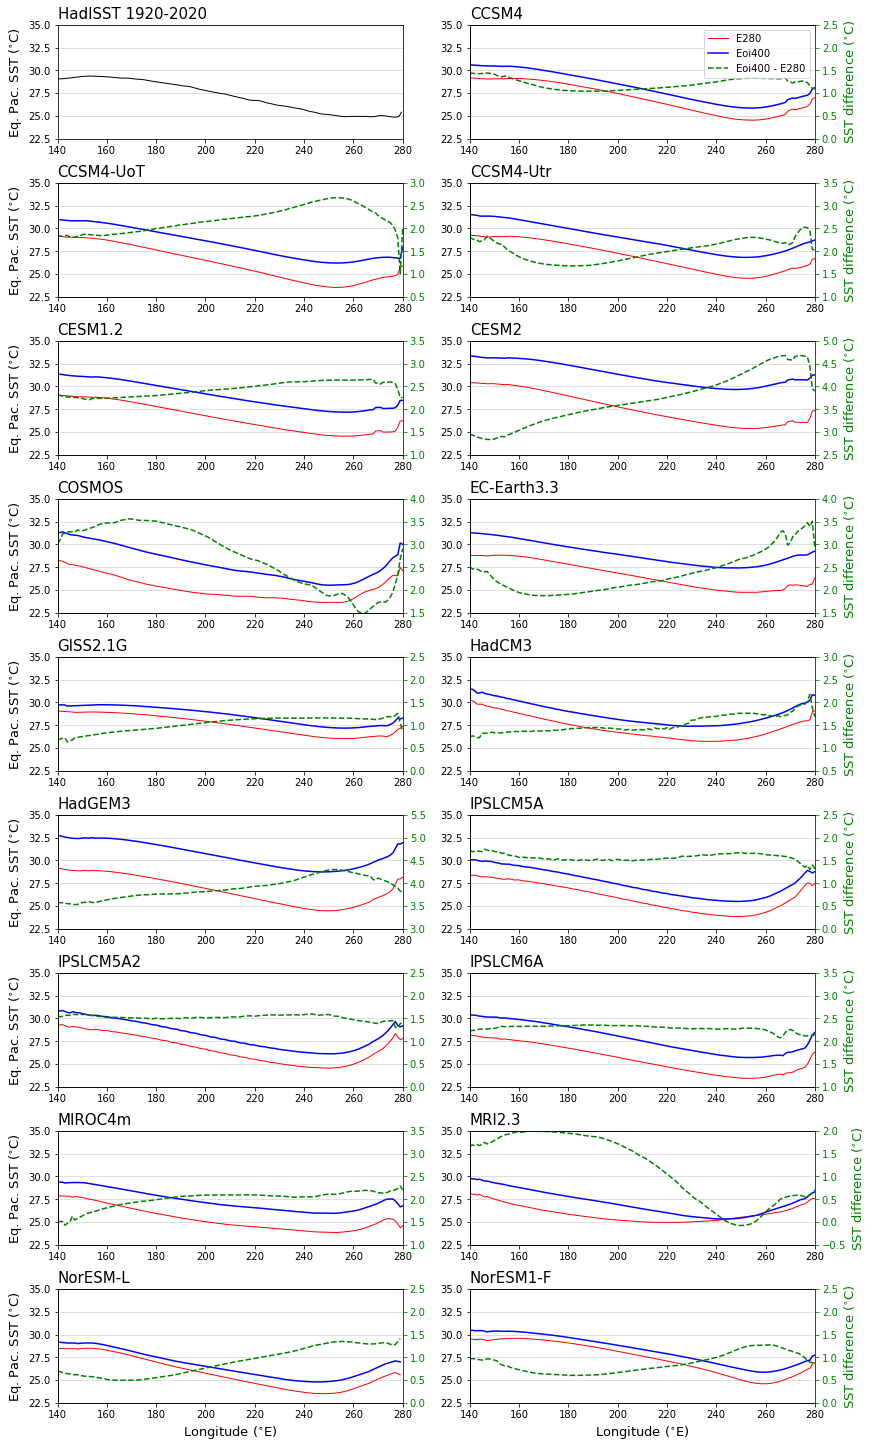

In [41]:
fig1, axs = plt.subplots(nrows=9, ncols=2, figsize=(figwidth2, 20), constrained_layout=True)
axs = trim_axs(axs, len(modellist)+1)

rightaxmin = np.array([0, .5, 1, 1, 2.5, 1.5, 1.5, 0, .5, 3, 0, 0, 1, 1, -.5, 0, 0])
rightaxd = 2.5

for ax, i in zip(axs, range(0,len(modellist)+1)):
    
    if i==0:
        ax.plot(lon_hadisst, hadisst, 'k-', linewidth = 1, alpha = 1, label = 'HadISST')
    else:
        model = modellist[i-1]
        a = Zonal_SST_gradient(model, run = 'E280', latbound = 5)
        p1 = a.plot(ax=ax, color='r', linestyle='-', linewidth = 1, label = 'E280')
        b = Zonal_SST_gradient(model, run = 'EOI400', latbound = 5)
        p2 = b.plot(ax=ax, color='b', linestyle='-', linewidth = 1.5, label = 'Eoi400')
   
    if np.mod(i,2)==0: ax.set_ylabel('Eq. Pac. SST ($^{\circ}$C)', fontsize=13)
    else: ax.set_ylabel('');
        
    if i>len(modellist)-2: ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=13)
    else: ax.set_xlabel('')
    
    ax.set_xlim([140, 280])
    ax.set_ylim([22.5, 35])
    
    ax.yaxis.grid(alpha=0.5)
    ax.get_yaxis().set_tick_params(which='minor', size=0)
    ax.get_yaxis().set_tick_params(which='minor', width=0)
    
    
    if i>0:
        ax2 = ax.twinx()
        p3 = (b-a).plot(ax=ax2, color='g', linestyle='--', linewidth = 1.5, label = 'Eoi400 - E280')
        if np.mod(i,2)==1:
            ax2.set_ylabel('SST difference ($^{\circ}$C)', color='g', fontsize=13)
        else: ax2.set_ylabel('')
        ax2.spines['right'].set_color('g')
        ax2.tick_params(axis='y', colors='g')
        ax2.set_ylim([rightaxmin[i-1], rightaxmin[i-1] + rightaxd])
    
    if i==1:
        ps = p1+p2+p3
        labs = [p.get_label() for p in ps]
        ax2.legend(ps, labs, loc = 'upper right')
#         ax2.legend(ps, labs, shadow=True, fontsize=12, loc='upper right', bbox_to_anchor=(0.9, 1.0))
    
    ax.set_title('')
    if i==0:
        ax.set_title('HadISST 1920-2020', loc='left', fontsize=15)
    else:
        ax2.set_title('')
        ax.set_title(modellist[i-1], loc='left', fontsize=15)
    
#     a1 = np.logical_not(np.isnan(a.values))
#     b1 = np.logical_not(np.isnan(b.values))
#     if i == 0:
#         zsg_lons   = a.longitude.values[a1]
#         zsg_e280   = np.zeros((len(zsg_lons), len(modellist)))
#         zsg_eoi400 = np.zeros((len(zsg_lons), len(modellist)))

#     zsg_e280[:,i]   = a.values; #a[a1]
#     zsg_eoi400[:,i] = b.values; #b[b1]
    
plt.savefig('figures/appendixfigure4.pdf', bbox_inches='tight')

# **Figure 8**

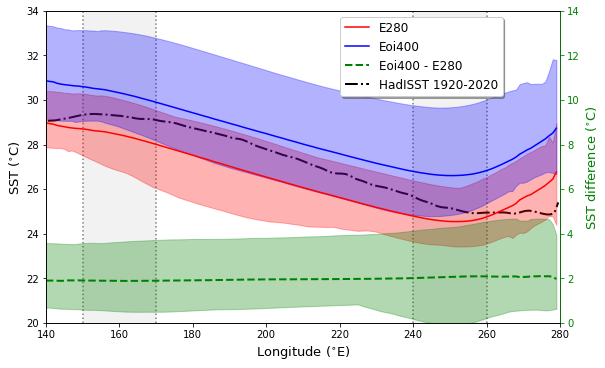

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8.3,5), constrained_layout=True)

## voor de fill_between: min/max of second, third, etc to min/max
d = 0

y = np.sort(zsg_e280, axis=1)
p1=ax.plot(zsg_lons, np.mean(y, axis=1), color='r', label='E280')
ax.fill_between(zsg_lons, y[:,d], y[:,(-1*d-1)], color='r', alpha=0.3)

y = np.sort(zsg_eoi400, axis=1)
p2=ax.plot(zsg_lons, np.mean(y, axis=1), color='b', label='Eoi400')
ax.fill_between(zsg_lons, y[:,d], y[:,(-1*d-1)], color='b', alpha=0.3)
ax.set_ylim([20, 34])
ax.set_ylabel('SST ($^{\circ}$C)', fontsize=13)

ax.set_xlim([140,280])

ax2 = ax.twinx()
y = np.sort((zsg_eoi400 - zsg_e280), axis=1)
p3=ax2.plot(zsg_lons, np.mean(y, axis=1), color='g', linestyle='--', linewidth = 2,label = 'Eoi400 - E280')
ax2.fill_between(zsg_lons, y[:,d], y[:,(-1*d-1)], color='g', alpha=0.3)
ax2.set_ylim([0, 14])
ax2.set_ylabel('SST difference ($^{\circ}$C)', color='g', fontsize=13)

# for i in range(len(modellist)):
#     ax2.plot(zsg_lons, (zsg_eoi400[:,i] - zsg_e280[:,i]), linestyle = '-', color = 'g', linewidth = 0.5, alpha = 0.8)

ax2.spines['right'].set_color('g')
ax2.tick_params(axis='y', colors='g')

ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=13)
# ax.set_title('5$^{\circ}$S - 5$^{\circ}$N mean SST: Pacific', fontsize=14);

p4=ax.plot(lon_hadisst, hadisst, color = 'k', linestyle='-.', linewidth=2, alpha=1, zorder=-1, label = 'HadISST 1920-2020')

ps = p1+p2+p3+p4
labs = [p.get_label() for p in ps]
ax2.legend(ps, labs, shadow=True, fontsize=12, loc='upper right', bbox_to_anchor=(0.9, 1.0))

ax.axvline(x=150, color='k', linestyle=':', alpha=0.5, zorder=-1)
ax.axvline(x=170, color='k', linestyle=':', alpha=0.5, zorder=-1)
ax.axvline(x=240, color='k', linestyle=':', alpha=0.5, zorder=-1)
ax.axvline(x=260, color='k', linestyle=':', alpha=0.5, zorder=-1)

ax.fill([150,170, 170,150], [18,18, 34,34], 'k', zorder=-1,alpha=0.05)
ax.fill([240,260, 260,240], [18,18, 34,34], 'k', zorder=-1,alpha=0.05)

# plt.savefig('figures/zonal_sst_gradient_v3.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/zonal_sst_gradient_v3.pdf', bbox_inches='tight')

# plt.savefig('figures/figure8.pdf', bbox_inches='tight')


### Calculate zonal SST gradient 

In [210]:
# longitude boxes for calculating West and East temperatures (warm pool / cold tongue)
# in degrees East
lonmin_W = 150; lonmax_W = 170;
lonmin_E = 240; lonmax_E = 260;

a = zsg_lons>lonmin_W; b = zsg_lons<lonmax_W; lons_W = a*b;
a = zsg_lons>lonmin_E; b = zsg_lons<lonmax_E; lons_E = a*b;

diff_e280   = np.mean(zsg_e280[lons_W,:], axis=0)   - np.mean(zsg_e280[lons_E,:], axis=0)
diff_eoi400 = np.mean(zsg_eoi400[lons_W,:], axis=0) - np.mean(zsg_eoi400[lons_E,:], axis=0)

# a = a[zsg_lons<lonmax_W]

### Calculate Nino3.4 s.d.

In [220]:
## Calculate Nino34 index time series 

std_e280    = np.zeros(len(modellist))
std_eoi400  = np.zeros(len(modellist))
# skew_e280   = np.zeros(len(modellist))
# skew_eoi400 = np.zeros(len(modellist))
# kurt_e280   = np.zeros(len(modellist))
# kurt_eoi400 = np.zeros(len(modellist))

trend_type = "linear" # linear detrending of Nino34 series

for i in range(0, len(modellist)):
    
    print('model = ' + modellist[i])
    
    ds = Nino34_timeseries(model = modellist[i], run='E280', trend = trend_type)
    if i==0: 
        nino_e280   = np.zeros((len(ds), len(modellist)))    
        nino_eoi400 = np.zeros((len(ds), len(modellist))) 
        
    nino_e280[:,i]   = ds
    nino_eoi400[:,i] = Nino34_timeseries(model = modellist[i], run='EOI400', trend = trend_type)
    
    std_e280[i]    = np.std(nino_e280[:,i])
    std_eoi400[i]  = np.std(nino_eoi400[:,i])
#     skew_e280[i]   = skew(nino_e280[:,i])
#     skew_eoi400[i] = skew(nino_eoi400[:,i])
#     kurt_e280[i]   = kurtosis(nino_e280[:,i])
#     kurt_eoi400[i] = kurtosis(nino_eoi400[:,i])        

model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


model = CESM1.2
model = CESM2
model = COSMOS


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = EC-Earth3.3


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


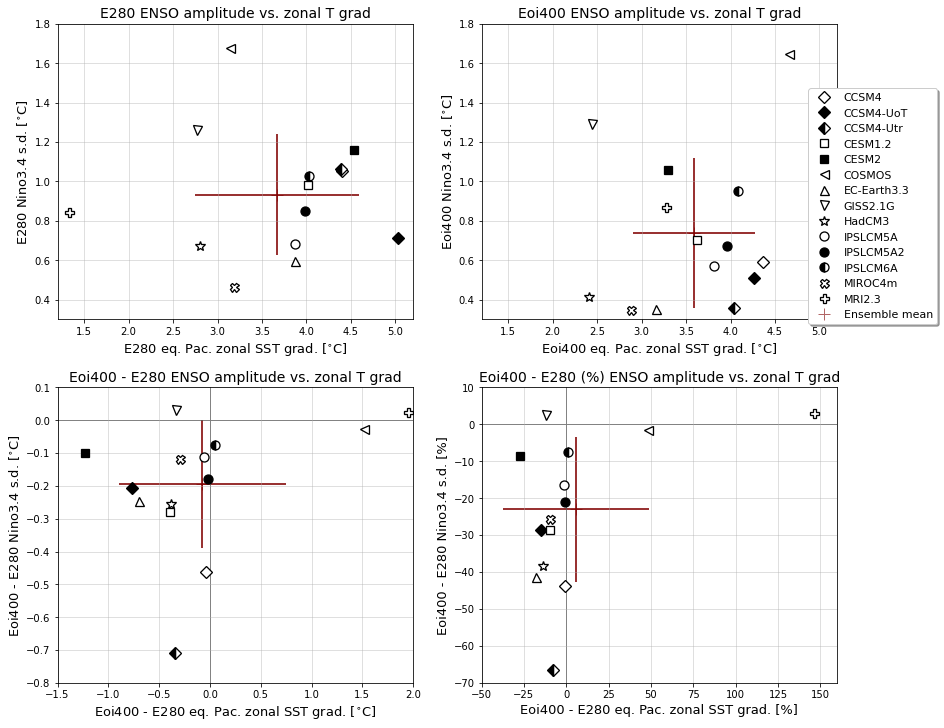

In [310]:
xlist = [diff_e280, diff_eoi400, (diff_eoi400-diff_e280), 100*(diff_eoi400-diff_e280)/diff_e280 ]
ylist = [std_e280,  std_eoi400,  (std_eoi400-std_e280),   100*(std_eoi400-std_e280)/std_e280 ]

xlabels = [r'E280 eq. Pac. zonal SST grad. [$^{\circ}$C]', r'Eoi400 eq. Pac. zonal SST grad. [$^{\circ}$C]',
          r'Eoi400 - E280 eq. Pac. zonal SST grad. [$^{\circ}$C]', r'Eoi400 - E280 eq. Pac. zonal SST grad. [%]']
ylabels = [r'E280 Nino3.4 s.d. [$^{\circ}$C]', r'Eoi400 Nino3.4 s.d. [$^{\circ}$C]',
          r'Eoi400 - E280 Nino3.4 s.d. [$^{\circ}$C]', r'Eoi400 - E280 Nino3.4 s.d. [%]']
titles  = [r'E280 ENSO amplitude vs. zonal T grad', r'Eoi400 ENSO amplitude vs. zonal T grad',
          r'Eoi400 - E280 ENSO amplitude vs. zonal T grad', r'Eoi400 - E280 (%) ENSO amplitude vs. zonal T grad']

xlims = [[1.2, 5.2], [1.2, 5.2], [-1.5, 2.0], [-50, 160]]
ylims = [[0.3, 1.8], [0.3, 1.8], [-0.8, 0.1], [-70,  10]]

markers = ['D', 'D', 'D', 's', 's', '<', '^', 'v', '*', 'o', 'o', 'o', 'X', 'P']
msize   = [8,    8,   8,   8,   8,   9,   9,   9,  10,   9,   9,   9,   9,   9]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'w', 'k', 'w', 'w', 'w']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'right', 'full', 'full']

fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(13,10), constrained_layout = True)

for j in range(4):
    
    i_ax = np.int(np.floor(0.5*j)); j_ax = np.int(np.mod(j,2))
    ax = axs[i_ax, j_ax]
    x = xlist[j]; y = ylist[j]
    
    # plot model values
    for i in range(len(modellist)):
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
            
    # plot ensemble mean +- std dev
    emcolor = 'maroon'
    ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'Ensemble mean', zorder=-1, alpha=0.6)    
    ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    
    # grid
    ax.grid(alpha=0.5);
    ax.plot(xlims[j], [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
    ax.plot([0,0], ylims[j], 'k-', alpha=0.6, zorder=-1, linewidth=1)

    # legend
    if j==1:
        ax.legend(fontsize=11)
#         ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*1.2, chartBox.height])
        ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.8), shadow=True, ncol=1, fontsize=11)
    
    ax.set_xlim(xlims[j]); ax.set_ylim(ylims[j])
    ax.set_xlabel(xlabels[j], fontsize=13)
    ax.set_ylabel(ylabels[j], fontsize=13)
    ax.set_title(titles[j], fontsize=14)
    
# plt.savefig('figures/Nino34_vs_zonalSSTgrad.png', bbox_inches='tight', dpi=200)


# **Figure 9**

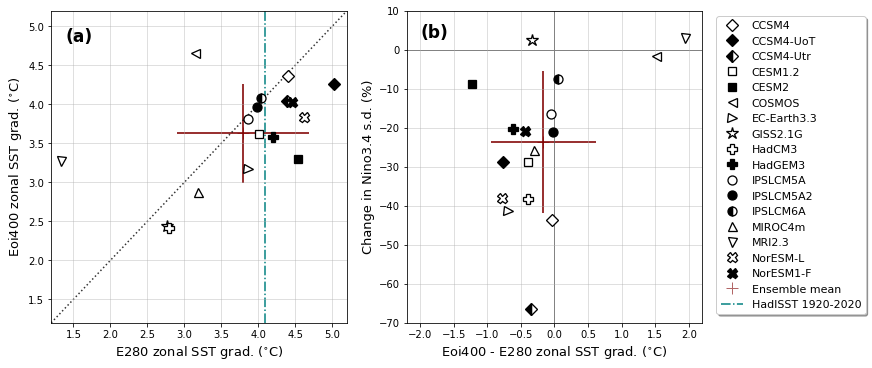

In [55]:
caption = True;
textx = [1.4, -2]; texty = [4.8, 3]; textlist = ['(a)', '(b)'];

xlist = [diff_e280, (diff_eoi400-diff_e280) ]
ylist = [diff_eoi400,   100*(std_eoi400-std_e280)/std_e280 ]

xlabels = [r'E280 zonal SST grad. ($^{\circ}$C)', r'Eoi400 - E280 zonal SST grad. ($^{\circ}$C)']
ylabels = [r'Eoi400 zonal SST grad. ($^{\circ}$C)', r'Change in Nino3.4 s.d. (%)']
titles  = [r'E280 vs. Eoi400 zonal T grad', r'Eoi400 - E280 (%) ENSO amplitude vs. zonal T grad']

xlims = [[1.2, 5.2], [-2.2, 2.2]]
ylims = [[1.2, 5.2], [-70,  10]]

markers = ['D', 'D', 'D', 's', 's', '<', '>', '*', 'P', 'P', 'o', 'o', 'o', '^', 'v', 'X', 'X']
msize   = [8,    8,   8,   8,   8,   9,   9,  13,  10,   10,   9,   9,   9,   9,   9,  10,  10]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'k', 'w', 'k', 'w', 'w', 'w', 'w', 'k']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 
              'full', 'right', 'full', 'full', 'full', 'full']

fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(figwidth2, 5), constrained_layout = True)

for j in range(2):
    
    ax = axs[j]
    x = xlist[j]; y = ylist[j]
    # plot model values
    for i in range(len(modellist)):
        p=ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
            
    # plot ensemble mean +- std dev
    emcolor = 'maroon'
    p2 = ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'Ensemble mean', zorder=-1, alpha=0.6)    
    ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    
    # grid
    ax.grid(alpha=0.5);
    ax.plot(xlims[j], [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
    ax.plot([0,0], ylims[j], 'k-', alpha=0.6, zorder=-1, linewidth=1)
    if j==0:
        ax.plot(xlims[j], ylims[j], 'k:', alpha=0.8, zorder = -1)

    # plot HadISST observations
    if j==0:
        ax.plot([zsg_hadisst, zsg_hadisst], ylims[j], color = 'teal', linestyle='-.', linewidth=1.5, alpha=1, zorder=-1, label = 'HadISST 1920-2020')
    if j==1: ax.plot([-100, -100], ylims[j], color = 'teal', linestyle='-.', linewidth=1.5, alpha=1, zorder=-1, label = 'HadISST 1920-2020')
  
    # legend
    if j==1:
        ax.legend(shadow=True, fontsize=11, loc='upper center', bbox_to_anchor=(1.3, 1))
    
    ax.set_xlim(xlims[j]); ax.set_ylim(ylims[j])
    ax.set_xlabel(xlabels[j], fontsize=labelfontsize)
    ax.set_ylabel(ylabels[j], fontsize=labelfontsize)
#     ax.set_title(titles[j], fontsize=14)
    
    if caption==True:
        ax.text(textx[j], texty[j], textlist[j], fontsize = 17, fontweight = 'bold')
    
# plt.savefig('figures/Nino34_vs_zonalSSTgrad_v3.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/Nino34_vs_zonalSSTgrad_v3.pdf', bbox_inches='tight')
# plt.savefig('figures/figure9.pdf', bbox_inches='tight')


In [221]:
zsg_hadisst

4.0933876

In [225]:
xlist = [diff_e280, (diff_eoi400-diff_e280) ]
ylist = [diff_eoi400,   100*(std_eoi400-std_e280)/std_e280 ]

x = ylist[1]

for i in range(len(modellist)):
    print(f'{x[i]:.2f}, {modellist[i]}')
print(f'{np.mean(x):.2f}, mean')
print(f'{np.std(x):.2f}, std')

-43.75, CCSM4
-28.72, CCSM4-UoT
-66.49, CCSM4-Utr
-28.65, CESM1.2
-8.66, CESM2
-1.63, COSMOS
-41.40, EC-Earth3.3
2.49, GISS2.1G
-38.30, HadCM3
-20.33, HadGEM3
-16.34, IPSLCM5A
-21.04, IPSLCM5A2
-7.43, IPSLCM6A
-25.57, MIROC4m
3.00, MRI2.3
-37.96, NorESM-L
-20.86, NorESM1-F
-23.63, mean
17.94, std


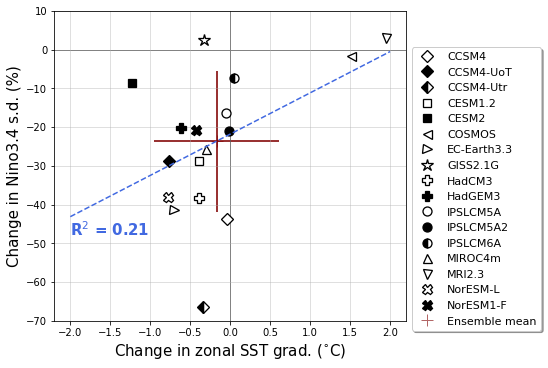

In [425]:

xlist = (diff_eoi400-diff_e280) 
ylist =  100*(std_eoi400-std_e280)/std_e280 

xlabels = [r'Change in zonal SST grad. ($^{\circ}$C)']
ylabels = [r'Change in Nino3.4 s.d. (%)']
# titles  = [r'Eoi400 - E280 (%) ENSO amplitude vs. zonal T grad']

xlims = [[-2.2, 2.2]]
ylims = [[-70,  10]]

markers = ['D', 'D', 'D', 's', 's', '<', '>', '*', 'P', 'P', 'o', 'o', 'o', '^', 'v', 'X', 'X']
msize   = [8,    8,   8,   8,   8,   9,   9,  13,  10,   10,   9,   9,   9,   9,   9,  10,  10]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'k', 'w', 'k', 'w', 'w', 'w', 'w', 'k']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 
              'full', 'right', 'full', 'full', 'full', 'full']

fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(7.5, 5), constrained_layout = True)

for j in range(1):
    

    x = xlist; y = ylist;
    # plot model values
    for i in range(len(modellist)):
        p=ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
            
    # plot ensemble mean +- std dev
    emcolor = 'maroon'
    p2 = ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'Ensemble mean', zorder=-1, alpha=0.6)    
    ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    
    # grid
    ax.grid(alpha=0.5);
    ax.plot(xlims[j], [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
    ax.plot([0,0], ylims[j], 'k-', alpha=0.6, zorder=-1, linewidth=1)


    # legend
    if j==0:
        ax.legend(shadow=True, fontsize=11.1, loc='upper center', bbox_to_anchor=(1.2, 0.9))
    
    ax.set_xlim(xlims[j]); ax.set_ylim(ylims[j])
    ax.set_xlabel(xlabels[j], fontsize=15)
    ax.set_ylabel(ylabels[j], fontsize=15)
#     ax.set_title(titles[j], fontsize=14)
    
    p = linregress(x,y)

    ax.plot(np.array([-2., 2.]), p.intercept + p.slope*np.array([-2., 2.]), color='royalblue', linestyle='--')
    ax.text(-2., -48, fr'R$^2$ = {p.rvalue**2:.2f}', color='royalblue', fontsize=15, fontweight='bold')

# plt.savefig('figures/Nino34_vs_zonalSSTgrad_v3.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/Nino34_vs_zonalSSTgrad_v3.pdf', bbox_inches='tight')
# plt.savefig('figures/figure9_NAC.pdf', bbox_inches='tight')


In [399]:
p.rvalue**2

0.20689872716307328

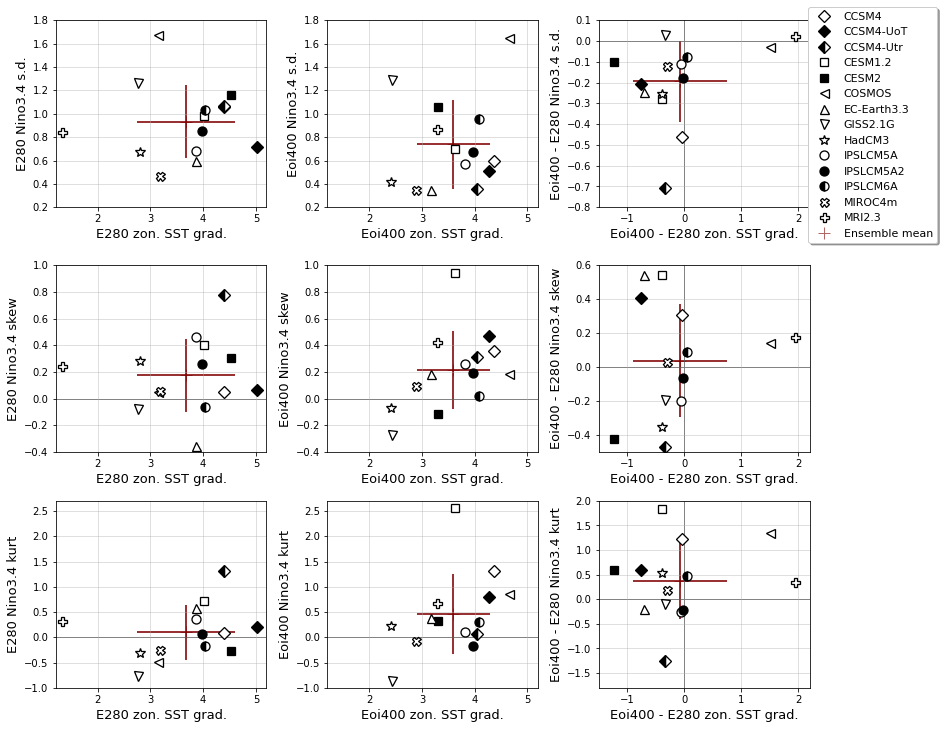

In [383]:
xlist = [diff_e280, diff_eoi400, (diff_eoi400-diff_e280), 
         diff_e280, diff_eoi400, (diff_eoi400-diff_e280),
         diff_e280, diff_eoi400, (diff_eoi400-diff_e280),]
ylist = [std_e280,  std_eoi400,  (std_eoi400-std_e280), 
         skew_e280,  skew_eoi400,  (skew_eoi400-skew_e280),
         kurt_e280,  kurt_eoi400,  (kurt_eoi400-kurt_e280),]

# xlabels = [r'E280 eq. Pac. zonal SST grad. [$^{\circ}$C]', r'Eoi400 eq. Pac. zonal SST grad. [$^{\circ}$C]',
#           r'Eoi400 - E280 eq. Pac. zonal SST grad. [$^{\circ}$C]', r'Eoi400 - E280 eq. Pac. zonal SST grad. [%]']
# ylabels = [r'E280 Nino3.4 s.d. [$^{\circ}$C]', r'Eoi400 Nino3.4 s.d. [$^{\circ}$C]',
#           r'Eoi400 - E280 Nino3.4 s.d. [$^{\circ}$C]', r'Eoi400 - E280 Nino3.4 s.d. [%]']
# titles  = [r'E280 ENSO amplitude vs. zonal T grad', r'Eoi400 ENSO amplitude vs. zonal T grad',
#           r'Eoi400 - E280 ENSO amplitude vs. zonal T grad', r'Eoi400 - E280 (%) ENSO amplitude vs. zonal T grad']

xlabels = ['E280 zon. SST grad.', 'Eoi400 zon. SST grad.', 'Eoi400 - E280 zon. SST grad.',
           'E280 zon. SST grad.', 'Eoi400 zon. SST grad.', 'Eoi400 - E280 zon. SST grad.',
           'E280 zon. SST grad.', 'Eoi400 zon. SST grad.', 'Eoi400 - E280 zon. SST grad.']
ylabels = ['E280 Nino3.4 s.d.', 'Eoi400 Nino3.4 s.d.', 'Eoi400 - E280 Nino3.4 s.d.',
           'E280 Nino3.4 skew', 'Eoi400 Nino3.4 skew', 'Eoi400 - E280 Nino3.4 skew',
           'E280 Nino3.4 kurt', 'Eoi400 Nino3.4 kurt', 'Eoi400 - E280 Nino3.4 kurt']

xlims = [[1.2, 5.2], [1.2, 5.2], [-1.5, 2.2],
         [1.2, 5.2], [1.2, 5.2], [-1.5, 2.2],
         [1.2, 5.2], [1.2, 5.2], [-1.5, 2.2]]
ylims = [[0.2, 1.8], [0.2, 1.8], [-0.8, 0.1],
         [-0.4, 1.0], [-0.4, 1.0], [-0.5, 0.6],
         [-1.0, 2.7], [-1.0, 2.7], [-1.8, 2.0]]

markers = ['D', 'D', 'D', 's', 's', '<', '^', 'v', '*', 'o', 'o', 'o', 'X', 'P']
msize   = [8,    8,   8,   8,   8,   9,   9,   9,  10,   9,   9,   9,   9,   9]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'w', 'k', 'w', 'w', 'w']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'right', 'full', 'full']

fig, axs = plt.subplots(ncols=3,nrows=3,figsize=(13,10), constrained_layout = True)

for j in range(9):
    
    i_ax = np.int(np.floor(j/3)); j_ax = np.int(np.mod(j,3))
    ax = axs[i_ax, j_ax]
    x = xlist[j]; y = ylist[j]
    
    # plot model values
    for i in range(len(modellist)):
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
            
    # plot ensemble mean +- std dev
    emcolor = 'maroon'
    ax.plot(np.mean(x), np.mean(y), color = emcolor, linestyle = 'None', marker ='+', markersize = 12, label = 'Ensemble mean', zorder=-1, alpha=0.6)    
    ax.plot([np.mean(x) - np.std(x), np.mean(x) + np.std(x)], [np.mean(y), np.mean(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    ax.plot([np.mean(x), np.mean(x)], [np.mean(y) - np.std(y), np.mean(y) + np.std(y)], 
        '-', color = emcolor, zorder=-1, linewidth=2, alpha=0.8)
    
    # grid
    ax.grid(alpha=0.5);
    ax.plot(xlims[j], [0,0], 'k-', alpha=0.6, zorder=-1, linewidth=1)
    ax.plot([0,0], ylims[j], 'k-', alpha=0.6, zorder=-1, linewidth=1)

    # legend
    if j==2:
        ax.legend(fontsize=11)
#         ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*1.2, chartBox.height])
        ax.legend(loc='upper center', bbox_to_anchor=(1.3, 1.1), shadow=True, ncol=1, fontsize=11)
    
    ax.set_xlim(xlims[j]); ax.set_ylim(ylims[j])
    ax.set_xlabel(xlabels[j], fontsize=13)
    ax.set_ylabel(ylabels[j], fontsize=13)
#     ax.set_title(titles[j], fontsize=14)
    
# plt.savefig('figures/Nino34_vs_zonalSSTgrad.png', bbox_inches='tight', dpi=200)


## Correlate mean state changes to Nino3.4 s.d. changes

In [23]:
for i in range(len(modellist)):

    model = modellist[i]
    print(model)
    a = Zonal_SST_gradient(model, 'E280', latbound = 23, latmean = False)
    b = Zonal_SST_gradient(model, 'EOI400', latbound = 23, latmean = False)

    ## normeren op tropical mean change? / global mean change -- normeren op cos(lat) (large scale features paper?)
    
    tempch = (b-a).values
    stdch  = ((std_eoi400[i] - std_e280[i])/std_e280[i]) * ~np.isnan(tempch)
#     stdch  = (std_eoi400[i] - std_e280[i]) * ~np.isnan(tempch)


    if i==0:
        temp_chs = np.zeros((tempch.shape[0], tempch.shape[1], len(modellist)))
        std_chs  = np.zeros((tempch.shape[0], tempch.shape[1], len(modellist)))
        lats = a.latitude.values
        lons = a.longitude.values
        
    temp_chs[:,:,i] = tempch
    std_chs[:,:,i]  = stdch

correlation = np.zeros((temp_chs.shape[0], temp_chs.shape[1]))
for i in range(correlation.shape[0]):
    for j in range(correlation.shape[1]):
        correlation[i,j] = np.corrcoef(std_chs[i,j,:], temp_chs[i,j,:])[0,1]

CCSM4
CCSM4-UoT
CCSM4-Utr
CESM1.2
CESM2
COSMOS
EC-Earth3.3


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/py

GISS2.1G
HadCM3
HadGEM3
IPSLCM5A
IPSLCM5A2
IPSLCM6A
MIROC4m


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


MRI2.3
NorESM-L
NorESM1-F


<ipython-input-24-0a2ae5fd5ff3>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(lons,lats,correlation, vmin = -.6, vmax=.6, cmap = cmap)


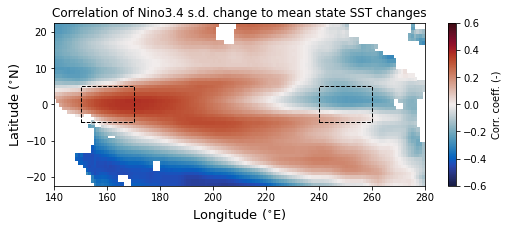

In [24]:
fig,ax = plt.subplots(1,1, figsize = (figwidth1, 3))

cmap = plt.get_cmap('cmo.balance')

im = ax.pcolormesh(lons,lats,correlation, vmin = -.6, vmax=.6, cmap = cmap)
# ax.contour(lons,lats,correlation, 0, colors='k', linestyles='dashed', linewidths=1)
fig.colorbar(im, ax=ax, label='Corr. coeff. (-)')

ax.set_xlabel('Longitude ($^{\circ}$E)', fontsize=labelfontsize)
ax.set_ylabel('Latitude ($^{\circ}$N)', fontsize=labelfontsize)
ax.set_title('Correlation of Nino3.4 s.d. change to mean state SST changes')

# x = [23,  20,  2];
# y = [25, 110, 55];

ax.add_patch(Rectangle((150,-5),20,10, fill=False, linestyle='--'));
ax.add_patch(Rectangle((240,-5),20,10, fill=False, linestyle='--'));

# ax.scatter(lons[y], lats[x], color='c', zorder=1)
# plt.savefig('figures/meanstate_Nino_changes_correlation.pdf', bbox_inches='tight')

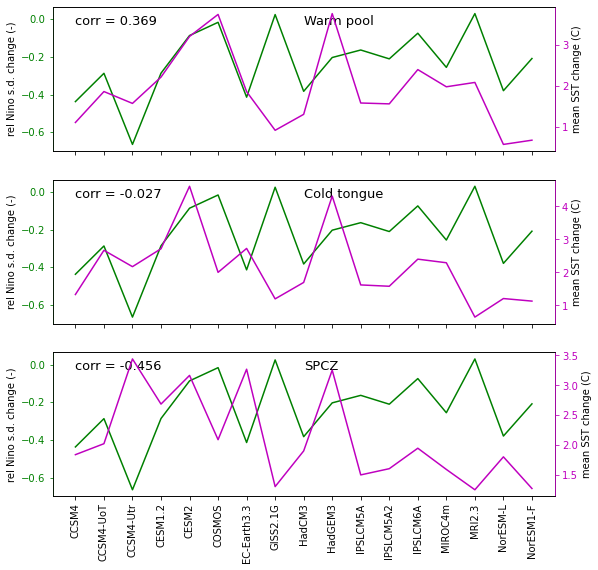

In [18]:
# 1= warm pool, 2=cold tongue, 3=spcz
titles = ['Warm pool', 'Cold tongue', 'SPCZ']
x = [23,  20,  2];
y = [25, 110, 55];

fig,axs = plt.subplots(3,1, figsize=(9,9))

for i in range(3):
    ax = axs[i]
    
    a=std_chs[x[i],y[i],:]; b = temp_chs[x[i],y[i],:];
    
    ax.plot(modellist,a,'g')
    ax.set_ylabel('rel Nino s.d. change (-)')
    ax2=plt.twinx(ax)
    ax2.plot(modellist,b,'m')
    ax2.set_ylabel('mean SST change (C)')
    if i==2: ax.tick_params(axis='x', rotation=90)
    else: ax.tick_params(labelbottom=False)

    ax2.spines['right'].set_color('m')
    ax2.tick_params(axis='y', colors='m')

    ax.spines['left'].set_color('g')
    ax.tick_params(axis='y', colors='g')
    corr = np.corrcoef(a, b)[0,1]
    ax.text(modellist[0], -0.03, f'corr = {np.round(corr,3)}', fontsize=13)
    ax.text(modellist[8], -0.03, titles[i], fontsize=13)

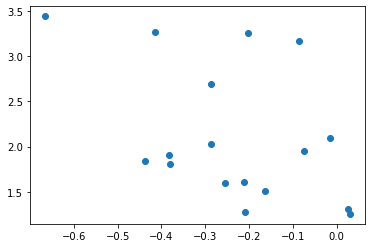

In [19]:
i =2
a=std_chs[x[i],y[i],:]; b = temp_chs[x[i],y[i],:];
plt.scatter(a,b)